In [2]:
import imblearn.datasets._zenodo as zenodo
print(zenodo.__doc__)

Collection of imbalanced datasets.

This collection of datasets has been proposed in [1]_. The
characteristics of the available datasets are presented in the table
below.

 ID    Name           Repository & Target           Ratio  #S       #F
 1     ecoli          UCI, target: imU              8.6:1  336      7
 2     optical_digits UCI, target: 8                9.1:1  5,620    64
 3     satimage       UCI, target: 4                9.3:1  6,435    36
 4     pen_digits     UCI, target: 5                9.4:1  10,992   16
 5     abalone        UCI, target: 7                9.7:1  4,177    10
 6     sick_euthyroid UCI, target: sick euthyroid   9.8:1  3,163    42
 7     spectrometer   UCI, target: >=44             11:1   531      93
 8     car_eval_34    UCI, target: good, v good     12:1   1,728    21
 9     isolet         UCI, target: A, B             12:1   7,797    617
 10    us_crime       UCI, target: >0.65            12:1   1,994    100
 11    yeast_ml8      LIBSVM, target: 8       

In [123]:
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score

from imblearn.datasets import fetch_datasets
from imblearn.under_sampling import NeighbourhoodCleaningRule, TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SPIDER
from imblearn.metrics import specificity_score

In [4]:
def benchmark(id):
    def pipeline(sampler=None):
        t0 = time()
        if sampler:
            X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        else:
            X_resampled, y_resampled = X_train, y_train
        t1 = time()

        logreg.fit(X_resampled, y_resampled)
        y_pred = logreg.predict(X_test)
        y_score = logreg.decision_function(X_test)

        conf_mtx = confusion_matrix(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_score)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)

        return dict(
            accuracy=accuracy,
            precision=precision,
            recall=recall,
            specificity=specificity,
            roc_auc=roc_auc,
            conf_mtx=conf_mtx,
            size=y_resampled.shape[0],
            time=(t1 - t0),
        )
    
    
    name = list(fetch_datasets())[id-1]
    dataset = fetch_datasets()[name]
    
    X, y = dataset.data, dataset.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

    logreg = LogisticRegression(solver='lbfgs', random_state=0, n_jobs=-1)

    ncr = NeighbourhoodCleaningRule(random_state=0, n_jobs=-1)
    tomek = TomekLinks(random_state=0, n_jobs=-1)
    enn = EditedNearestNeighbours(random_state=0, n_jobs=-1)
    
    smote = SMOTE(random_state=0, n_jobs=-1)
    adasyn = ADASYN(random_state=0, n_jobs=-1)
    
    weak = SPIDER(kind='weak', n_jobs=-1)
    relabel = SPIDER(kind='relabel', n_jobs=-1)
    strong = SPIDER(kind='strong', n_jobs=-1)

    results_none = pipeline()
    results_smote = pipeline(smote)
    results_adasyn = pipeline(adasyn)
    results_ncr = pipeline(ncr)
    results_tomek = pipeline(tomek)
    results_enn = pipeline(enn)
    results_weak = pipeline(weak)
    results_relabel = pipeline(relabel)
    results_strong = pipeline(strong)

    results_list =  [
        results_none,
        results_smote, results_adasyn,
        results_ncr, results_tomek, results_enn,
        results_weak, results_relabel, results_strong,
    ]

    accuracies =    [r['accuracy'] for r in results_list]
    precisions =    [r['precision'] for r in results_list]
    recalls =       [r['recall'] for r in results_list]
    specificities = [r['specificity'] for r in results_list]
    roc_aucs =      [r['roc_auc'] for r in results_list]
    sizes =         [r['size'] for r in results_list]
    times =         [r['time'] for r in results_list]

    conf_mtxs = np.vstack([r['conf_mtx'].ravel() for r in results_list])
    tns = conf_mtxs[:, 0]
    fps = conf_mtxs[:, 1]
    fns = conf_mtxs[:, 2]
    tps = conf_mtxs[:, 3]

    results_dict = dict(
        accuracy=accuracies,
        precision=precisions,
        recall=recalls,
        specificity=specificities,
        roc_auc=roc_aucs,
        tp=tps,
        fp=fps,
        tn=tns,
        fn=fns,
        size=sizes,
        time=times,
    )

    index = pd.Index([
        'none',
        'smote', 'adasyn',
        'ncr', 'tomek', 'enn',
        'weak', 'relabel', 'strong'
    ], name=dataset.DESCR)
    results_df = pd.DataFrame(results_dict, index=index)

    results_df.to_pickle(f'../benchmark_{dataset.DESCR}.pkl')
    return results_df

#### Notes
- NCR and SPIDER (Weak & Relabel) are roughly same time complexity
    - O(n^2)?
    - NVM probably knn_correct since Strong is affected twice NVM
    - locate_neighbors is O(n^2) and the knn_corrects call loc_neigh with larger X's?
- SPIDER (Strong) is ~2x slower

In [131]:
!ls "*pkl"

ls: *pkl: No such file or directory


In [128]:
cwd = Path.cwd()
[file for file in cwd.parent.iterdir() if file.suffix == 'pkl']

[]

            accuracy  precision    recall  specificity
car_eval_4                                            
none        0.979769   0.800000  0.615385     0.993994
smote       0.965318   0.520000  1.000000     0.963964
ncr         0.979769   0.800000  0.615385     0.993994
weak        0.979769   0.666667  0.923077     0.981982
relabel     0.979769   0.666667  0.923077     0.981982
strong      0.973988   0.590909  1.000000     0.972973


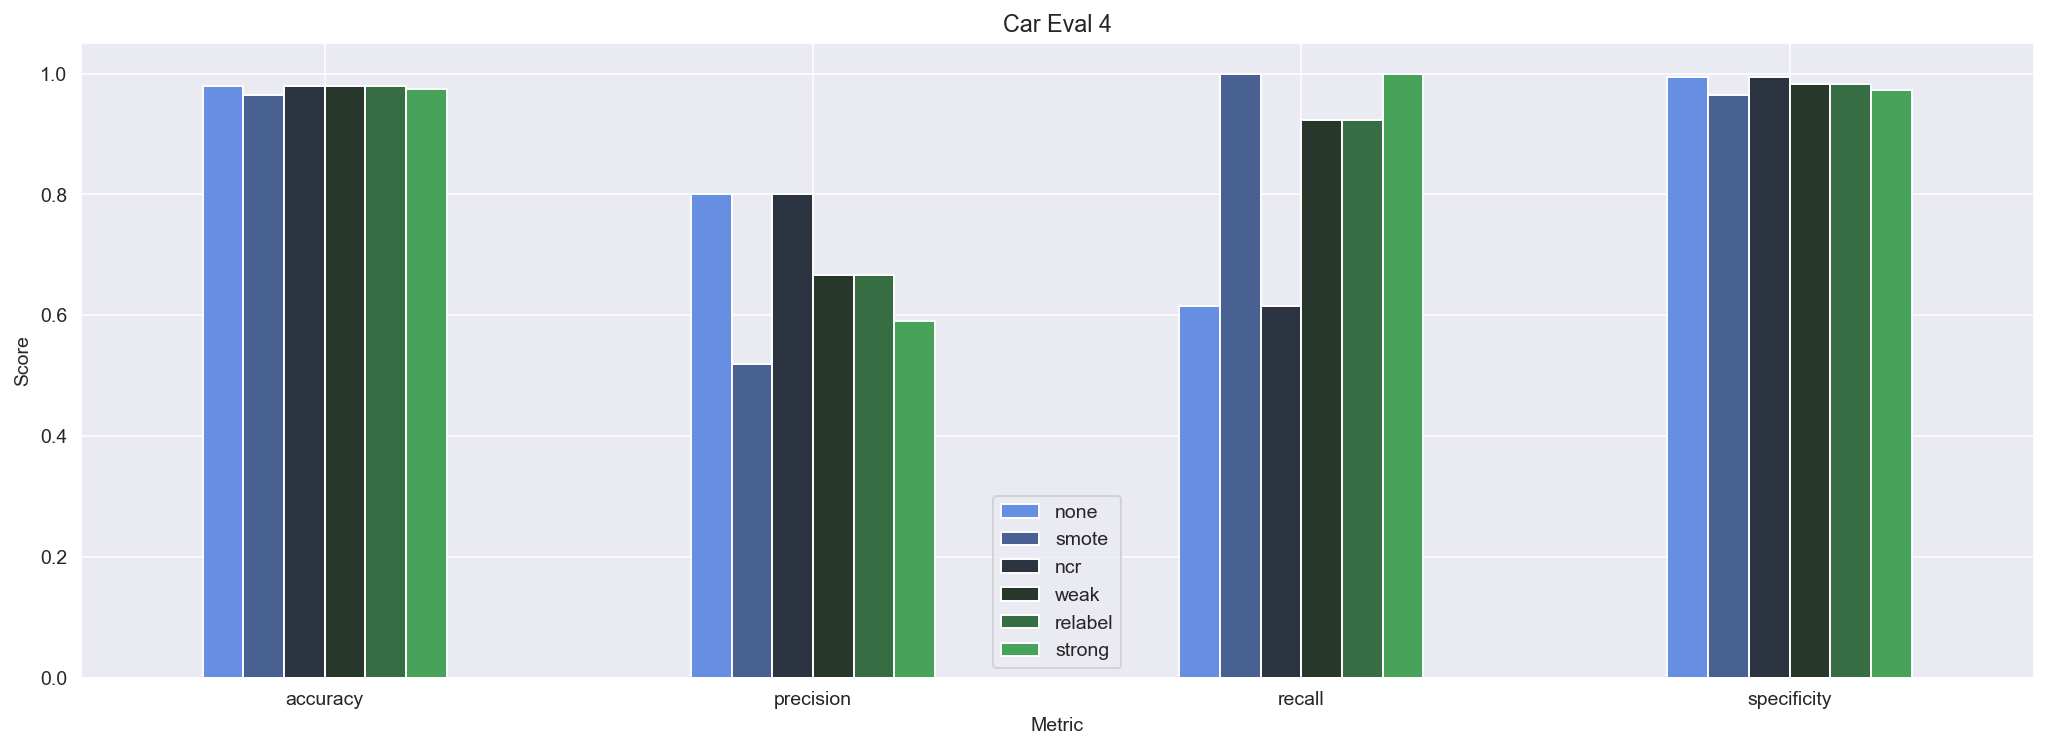

In [122]:
df = pd.read_pickle('../benchmark_car_eval_4.pkl')

# todo: output CSV
methods = ['none', 'smote', 'ncr', 'weak', 'relabel', 'strong']
metrics = ['accuracy', 'precision', 'recall', 'specificity']
print(df.loc[methods, metrics])

def plot_benchmark(df, save=True):
    palette = sns.diverging_palette(255, 133, l=60, n=6, center="dark")
    # palette = 'inferno'
    sns.set_style('darkgrid')
    sns.set_palette(palette)
    title = " ".join(df.index.name.split("_")).title()
    name = df.index.name
    df.index.name = None
    fig = plt.figure(dpi=140)
    df.loc[methods, metrics].T.plot.bar(figsize=(18, 6), title=title, rot=0, ax=plt.gca())
    plt.xlabel('Metric')
    plt.ylabel('Score')
    if save:
        plt.savefig(f'../benchmark_{name}.png', bbox_inches='tight')

In [39]:
df.append?

In [81]:
ls ../benchmark*

../benchmark_abalone.pkl         ../benchmark_ozone_level.pkl
../benchmark_abalone_19.pkl      ../benchmark_pen_digits.pkl
../benchmark_arrhythmia.pkl      ../benchmark_satimage.pkl
../benchmark_car_eval_34.pkl     ../benchmark_scene.pkl
../benchmark_car_eval_4.pkl      ../benchmark_sick_euthyroid.pkl
../benchmark_coil_2000.pkl       ../benchmark_solar_flare_m0.pkl
../benchmark_ecoli.pkl           ../benchmark_spectrometer.pkl
../benchmark_isolet.pkl          ../benchmark_thyroid_sick.pkl
../benchmark_letter_img.pkl      ../benchmark_us_crime.pkl
../benchmark_libras_move.pkl     ../benchmark_webpage.pkl
../benchmark_mammography.pkl     ../benchmark_wine_quality.pkl
../benchmark_oil.pkl             ../benchmark_yeast_me2.pkl
../benchmark_optical_digits.pkl  ../benchmark_yeast_ml8.pkl


In [ ]:
# a
# c    [tn 0    fp 1]
# t    [fn 2    tp 3]
# u
# a   predicted
# l

## Sparse
Same results, just in a different order

In [156]:
from sklearn.utils import safe_mask, safe_indexing

In [210]:
name = 'wine_quality'
dataset = fetch_datasets()[name]

X, y = dataset.data, dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

Xspr, yspr = weak.fit_resample(sp.lil_matrix(X_train), y_train)
Xspr = Xspr.toarray()

Xarr, yarr = weak.fit_resample(X_train, y_train)

Xarr.sort(axis=0)
Xspr.sort(axis=0)

np.isclose(Xspr, Xarr).all()

True

In [243]:
amplify_amounts = np.array([1, 0, 0, 3, 2])
X = np.arange(len(amplify_amounts))[:, np.newaxis]
y = np.array([0, 0, 1, 1, 0])

In [245]:
X = sp.lil_matrix(X)

In [246]:
if sp.issparse(X):
    X_parts = []
    y_parts = []
    for amount in filter(bool, np.unique(amplify_amounts)):
        mask = safe_mask(X, amplify_amounts == amount)
        X_part = X[mask]
        y_part = y[mask]
        X_parts.extend([X_part] * amount)
        y_parts.extend([y_part] * amount)
    X_spr = sp.vstack(X_parts)
    X_spr = X_spr.toarray()
    y_spr = np.hstack(y_parts)
else:
    X_new = np.repeat(X, amplify_amounts, axis=0)
    y_new = np.repeat(y, amplify_amounts)

In [247]:
X_new

array([[0],
       [3],
       [3],
       [3],
       [4],
       [4]])

In [248]:
X_spr

array([[0],
       [4],
       [4],
       [3],
       [3],
       [3]], dtype=int64)

In [249]:
y_new

array([0, 1, 1, 1, 0, 0])

In [250]:
y_spr

array([0, 0, 0, 1, 1, 1])

In [238]:
np.sort(X_new, axis=0)

array([[0],
       [3],
       [3],
       [3],
       [4],
       [4]])

In [265]:
np.sort(X_spr, axis=0)

array([[0],
       [3],
       [3],
       [3],
       [4],
       [4]], dtype=int64)

In [263]:
y_new[np.argsort(X_new, axis=0).ravel()]

array([0, 1, 1, 1, 0, 0])

In [264]:
y_spr[np.argsort(X_spr, axis=0).ravel()]

array([0, 1, 1, 1, 0, 0])